In [2]:
# Setting the environment variables

In [3]:
import os
import sys
os.environ["PYSPARK_PYTHON"]="/usr/bin/python3"
os.environ["PYSPARK_DRIVER_PYTHON"]="/usr/bin/python3"
os.environ["PYSPARK_DRIVER_PYTHON_OPTS"]="notebook --no-browser"
os.environ["JAVA_HOME"] = "/usr/java/jdk1.8.0_161/jre"
os.environ["SPARK_HOME"] = "/home/ec2-user/spark-2.4.4-bin-hadoop2.7"
os.environ["PYLIB"] = os.environ["SPARK_HOME"] + "/python/lib"
sys.path.insert(0, os.environ["PYLIB"] + "/py4j-0.10.7-src.zip")
sys.path.insert(0, os.environ["PYLIB"] + "/pyspark.zip")

# Ecommerce Churn Assignment

The aim of the assignment is to build a model that predicts whether a person purchases an item after it has been added to the cart or not. Being a classification problem, you are expected to use your understanding of all the three models covered till now. You must select the most robust model and provide a solution that predicts the churn in the most suitable manner. 

For this assignment, you are provided the data associated with an e-commerce company for the month of October 2019. Your task is to first analyse the data, and then perform multiple steps towards the model building process.

The broad tasks are:
- Data Exploration
- Feature Engineering
- Model Selection
- Model Inference

### Data description

The dataset stores the information of a customer session on the e-commerce platform. It records the activity and the associated parameters with it.

- **event_time**: Date and time when user accesses the platform
- **event_type**: Action performed by the customer
            - View
            - Cart
            - Purchase
            - Remove from cart
- **product_id**: Unique number to identify the product in the event
- **category_id**: Unique number to identify the category of the product
- **category_code**: Stores primary and secondary categories of the product
- **brand**: Brand associated with the product
- **price**: Price of the product
- **user_id**: Unique ID for a customer
- **user_session**: Session ID for a user


### Initialising the SparkSession

The dataset provided is 5 GBs in size. Therefore, it is expected that you increase the driver memory to a greater number. You can refer to notebook 1 for the steps involved here.

In [4]:
# Spark environment
from pyspark import SparkConf
from pyspark.sql import SparkSession

In [5]:
# initialising the session with 14 GB driver memory
MAX_MEMORY = "14G"

spark = SparkSession \
    .builder \
    .appName("demo") \
    .config("spark.driver.memory", MAX_MEMORY) \
    .getOrCreate()

spark

In [6]:
# Spark session with 14 GB driver memory
spark.sparkContext.getConf().get('spark.driver.memory')

'14G'

In [7]:
#importing required libraries
import pandas as pd
from matplotlib import pyplot as plt
from pyspark.sql.functions import *

In [8]:
# Loading the clean data
df= spark.read.parquet("cleaned_df.parquet")

<hr>

## Task 3: Model Selection
3 models for classification:	
- Logistic Regression
- Decision Tree
- Random Forest

### Model 1: Logistic Regression

In [9]:
df.printSchema()

root
 |-- brand: string (nullable = true)
 |-- price: double (nullable = true)
 |-- event_day: integer (nullable = true)
 |-- category_2: string (nullable = true)
 |-- user_activity_count: long (nullable = true)
 |-- user_product: long (nullable = true)
 |-- user_category_2: long (nullable = true)
 |-- user_mean_spend: double (nullable = true)
 |-- user_session_count: long (nullable = true)
 |-- hour_bin: integer (nullable = true)
 |-- label: integer (nullable = true)



In [10]:
df.show(2)

+-------+------+---------+----------+-------------------+------------+---------------+------------------+------------------+--------+-----+
|  brand| price|event_day|category_2|user_activity_count|user_product|user_category_2|   user_mean_spend|user_session_count|hour_bin|label|
+-------+------+---------+----------+-------------------+------------+---------------+------------------+------------------+--------+-----+
|samsung|283.62|        3|smartphone|                  2|           2|              3| 270.4633333333333|                 2|       2|    0|
| xiaomi|138.71|        4|smartphone|                  2|           2|              3|213.38666666666668|                 2|       3|    0|
+-------+------+---------+----------+-------------------+------------+---------------+------------------+------------------+--------+-----+
only showing top 2 rows



#### Feature Transformation

In [11]:
# Check if only the required columns are present to build the model
# If not, drop the redundant columns
df.columns

['brand',
 'price',
 'event_day',
 'category_2',
 'user_activity_count',
 'user_product',
 'user_category_2',
 'user_mean_spend',
 'user_session_count',
 'hour_bin',
 'label']

In [12]:
# Categorising the attributes into its type - Continuous and Categorical
cat_cols=['brand','category_2', 'event_day', 'hour_bin']
num_cols=['price', 'user_product', 'user_category_2', 'user_mean_spend', 'user_session_count', 'user_activity_count']
output_label = 'label'

In [13]:
# importing all the required libraries
from pyspark.ml.feature import OneHotEncoderEstimator,StringIndexer,VectorAssembler

In [14]:
# Empty list to store the steps of pipeline
steps=[]

In [15]:
# Feature transformation for categorical features
for categoricalCol in cat_cols:
    stringIndexer=StringIndexer(inputCol=categoricalCol,outputCol=categoricalCol+'_index').setHandleInvalid("keep")
    encoder=OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()],outputCols=\
                                   [categoricalCol+"_enc"])
    steps+=[stringIndexer,encoder]

In [16]:
# Vector assembler to combine all the features
# Defining the vectore assembler to combine all the features
assemblerInputs=[col+"_enc" for col in cat_cols]+num_cols
assembler=VectorAssembler(inputCols=assemblerInputs,outputCol="features")
steps+=[assembler]

In [17]:
# Pipeline for the tasks
from pyspark.ml import Pipeline
pipeline=Pipeline(stages=steps)

In [18]:
# Transforming the dataframe df
final_df = pipeline.fit(df).transform(df)

In [19]:
# Schema of the transformed df
final_df.printSchema()

root
 |-- brand: string (nullable = true)
 |-- price: double (nullable = true)
 |-- event_day: integer (nullable = true)
 |-- category_2: string (nullable = true)
 |-- user_activity_count: long (nullable = true)
 |-- user_product: long (nullable = true)
 |-- user_category_2: long (nullable = true)
 |-- user_mean_spend: double (nullable = true)
 |-- user_session_count: long (nullable = true)
 |-- hour_bin: integer (nullable = true)
 |-- label: integer (nullable = true)
 |-- brand_index: double (nullable = false)
 |-- brand_enc: vector (nullable = true)
 |-- category_2_index: double (nullable = false)
 |-- category_2_enc: vector (nullable = true)
 |-- event_day_index: double (nullable = false)
 |-- event_day_enc: vector (nullable = true)
 |-- hour_bin_index: double (nullable = false)
 |-- hour_bin_enc: vector (nullable = true)
 |-- features: vector (nullable = true)



In [20]:
# Checking the elements of the transformed df - Top 20 rows
final_df.show()

+--------+-------+---------+----------+-------------------+------------+---------------+------------------+------------------+--------+-----+-----------+--------------+----------------+--------------+---------------+-------------+--------------+-------------+--------------------+
|   brand|  price|event_day|category_2|user_activity_count|user_product|user_category_2|   user_mean_spend|user_session_count|hour_bin|label|brand_index|     brand_enc|category_2_index|category_2_enc|event_day_index|event_day_enc|hour_bin_index| hour_bin_enc|            features|
+--------+-------+---------+----------+-------------------+------------+---------------+------------------+------------------+--------+-----+-----------+--------------+----------------+--------------+---------------+-------------+--------------+-------------+--------------------+
| samsung| 283.62|        3|smartphone|                  2|           2|              3| 270.4633333333333|                 2|       2|    0|        0.0|(20,

In [22]:
# Storing the transformed df in S3 bucket to prevent repetition of steps again
final_df.coalesce(1).write.option("header", "true").parquet("final_df.parquet")

**Feature Scaling**

In [23]:
# Scaling the features vector
from pyspark.ml.feature import MinMaxScaler
scaler = MinMaxScaler().setInputCol("features").setOutputCol("scaled_features")
logistic_df = scaler.fit(final_df).transform(final_df)

In [24]:
# Scaled features
logistic_df.select("features","scaled_features").head()

Row(features=SparseVector(75, {0: 1.0, 20: 1.0, 59: 1.0, 65: 1.0, 69: 283.62, 70: 2.0, 71: 3.0, 72: 270.4633, 73: 2.0, 74: 2.0}), scaled_features=DenseVector([1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.1098, 0.0013, 0.0006, 0.1047, 0.0005, 0.0031]))

#### Train-test split

In [25]:
# Splitting the data into train and test (Remember you are expected to compare the model later)
train_data, test_data =logistic_df.randomSplit([0.7,0.3], seed=100)

In [26]:
# Number of rows in train
train_data.count()

549095

In [27]:
# Number of rows in test
test_data.count()

235266

#### Model Fitting

In [28]:
# Building the model
# Importing the library for Logistic regression
from pyspark.ml.classification import LogisticRegression

# create the logistic model, configure it and call fit it to the data. 
log_reg = LogisticRegression(featuresCol='scaled_features', labelCol='label')

In [29]:
# Fitting the model on transformed df
model = log_reg.fit(train_data)

In [30]:
# Fit on train data
predictions_train = model.transform(train_data)

#### Model Analysis

Required Steps:
- Fit on test data
- Performance analysis
    - Appropriate Metric with reasoning
    - Threshold selection

In [31]:
# Fit on test data
predictions_test = model.transform(test_data)

In [32]:
# Predictions on the test data
predictions_test.select('label', 'prediction').show()

+-----+----------+
|label|prediction|
+-----+----------+
|    1|       1.0|
|    1|       1.0|
|    1|       1.0|
|    0|       1.0|
|    0|       1.0|
|    1|       0.0|
|    0|       0.0|
|    1|       1.0|
|    0|       1.0|
|    0|       1.0|
|    1|       1.0|
|    1|       1.0|
|    1|       1.0|
|    1|       1.0|
|    1|       1.0|
|    1|       1.0|
|    1|       1.0|
|    1|       1.0|
|    1|       1.0|
|    1|       1.0|
+-----+----------+
only showing top 20 rows



In [33]:
# Performance evaluation
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator()
# ROC Curve
print('Test Area Under ROC', evaluator.evaluate(predictions_train))
print('Test Area Under ROC', evaluator.evaluate(predictions_test))

Test Area Under ROC 0.7092825632054874
Test Area Under ROC 0.7092499990705057


In [34]:
# Performance evaluation
train_eval = model.evaluate(train_data)
test_eval = model.evaluate(test_data)

# fMeasure
print('fMeasure on Training data', train_eval.fMeasureByLabel())
print('fMeasure on Test data', test_eval.fMeasureByLabel())

fMeasure on Training data [0.4461440172987849, 0.7666117020312755]
fMeasure on Test data [0.44643737628538155, 0.7656786441334207]


In [35]:
# Threshold optimisation
thresh_results = predictions_train.select('label','probability','prediction')
thresh_results.show(5)

+-----+--------------------+----------+
|label|         probability|prediction|
+-----+--------------------+----------+
|    1|[0.63178576267841...|       0.0|
|    0|[0.49684016656274...|       1.0|
|    0|[0.55074823719078...|       0.0|
|    1|[0.25545541849683...|       1.0|
|    1|[0.22431074342995...|       1.0|
+-----+--------------------+----------+
only showing top 5 rows



In [36]:
from pyspark.sql.functions import udf, when
from pyspark.sql.types import FloatType

element_extrac=udf(lambda v:float(v[1]),FloatType())

result_list = []       # to store the values of accuracy, precision and recall

threshold_list = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

In [37]:
for i in threshold_list:
    test_pred = thresh_results.withColumn('label_p',when(element_extrac(thresh_results["probability"]) >= i, 1).otherwise(0))
    TP = test_pred.filter("label==1 AND label_p==1").count()
    FP = test_pred.filter("label==0 AND label_p==1").count()
    FN = test_pred.filter("label==1 AND label_p==0").count()
    TN = test_pred.filter("label==0 AND label_p==0").count()    
    list1 = []
    list1.append(i)
    list1.append(TP)
    list1.append(TN)
    list1.append(FP)
    list1.append(FN)
    result_list.append(list1)

In [38]:
# Converting the list into dataframe
from pyspark.sql.types import *

schema = StructType([StructField('threshold', FloatType(), True),
                      StructField('TP', IntegerType(), True),
                      StructField('TN', IntegerType(), True),
                      StructField('FP', IntegerType(), True),
                      StructField('FN', IntegerType(), True)])


# create a rdd from the list
rdd = spark.sparkContext.parallelize(result_list)


# create a spark dataframe form rdd
thresh_df = spark.createDataFrame(rdd,schema)

In [39]:
# Generating the required metrics
thresh_df = thresh_df.withColumn('accuracy',((thresh_df['TP']+thresh_df['TN'])/(thresh_df['TP']+thresh_df['FP']+thresh_df['TN']+thresh_df['FN'])))
thresh_df = thresh_df.withColumn('recall',(thresh_df['TP'])/(thresh_df['TP']+thresh_df['FN']))
thresh_df = thresh_df.withColumn('precision',(thresh_df['TP'])/(thresh_df['TP']+thresh_df['FP']))
thresh_df = thresh_df.withColumn('fscore',(2*thresh_df['recall']*thresh_df['precision'])/(thresh_df['recall']+thresh_df['precision']))

In [40]:
pandas_df = thresh_df.toPandas()

In [41]:
pandas_df

,threshold,TP,TN,FP,FN,accuracy,recall,precision,fscore
0,0.05,340431,70,208592,2,0.620113,0.999994,0.620067,0.765481
1,0.10,340408,209,208453,25,0.620324,0.999927,0.620208,0.765569
2,0.20,340204,758,207904,229,0.620953,0.999327,0.620688,0.765759
3,0.30,339259,3596,205066,1174,0.624400,0.996551,0.623266,0.766897
4,0.40,333121,18931,189731,7312,0.641150,0.978521,0.637123,0.771752
5,0.50,296149,72626,136036,44284,0.671605,0.869919,0.685237,0.766612
6,0.60,206780,146386,62276,133653,0.643178,0.607403,0.768539,0.678536
7,0.70,117473,184748,23914,222960,0.550398,0.345069,0.830861,0.487622


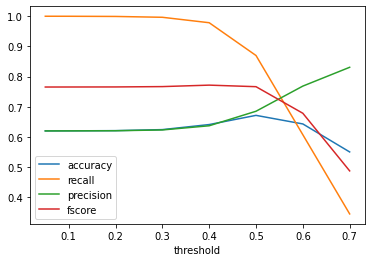

In [42]:
# Plotting the different measures
import matplotlib.pyplot as plt

# create the plot
pandas_df.plot.line(x='threshold', y=['accuracy','recall','precision', 'fscore'])

# display the plot
plt.show()

Selecting the threshold value as **0.55**

In [43]:
test_pred = thresh_results.withColumn('label_p',when(element_extrac(thresh_results["probability"]) >= 0.55, 1).otherwise(0))
TP = test_pred.filter("label==1 AND label_p==1").count()
FP = test_pred.filter("label==0 AND label_p==1").count()
FN = test_pred.filter("label==1 AND label_p==0").count()
TN = test_pred.filter("label==0 AND label_p==0").count() 

In [44]:
accuracy = (TP + TN)/(TP + TN + FP + FN)
print("Accuracy score =",accuracy)

Accuracy score = 0.6702446753294057


In [45]:
precision = (TP)/(TP+FP)
print("Precision =",precision)

Precision = 0.7227686234602761


In [46]:
recall = (TP)/(TP+FN)
print("Recall =",recall)

Recall = 0.7594152153287137


In [47]:
fscore = (2*precision*recall)/(precision + recall)
print("F score =",fscore)

F score = 0.7406388808912991


**Recall** is the appropriate metric since here we are concentrating on the churn. ie the 1's. 
<br>Here we can see that the recall is about 0.76